# Лабораторная работа №2
выполнил: Стрыгин Денис группа: 406

In [3]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
import cv2
from torchvision.datasets import VOCSegmentation
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, Resize

In [4]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [5]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [6]:
val_augs = Compose([
    Resize(256, 256)
])

In [7]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .


In [8]:
validation_dataset = PascalVOCSearchDataset('.',download = True, transform = val_augs)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [9]:
assert validation_dataset[0][0].shape == train_dataset[0][0].shape
assert validation_dataset[0][1].shape == train_dataset[0][1].shape

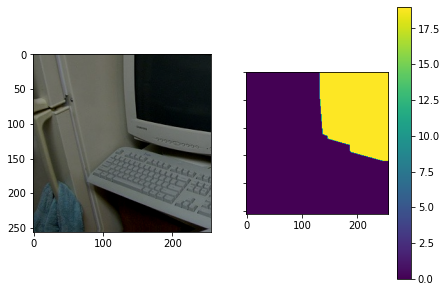

In [10]:
def print_img(train_dataset, n):
  img,lbl = train_dataset[n]
  fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
  ax = ax.ravel()

  ax[0].imshow(img.permute(1,2,0))
  lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
  plt.colorbar(lbl_plot,ax = ax[1])
  plt.show()

print_img(train_dataset, 1)

In [11]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [12]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [14]:
val_dataloader = DataLoader(validation_dataset, batch_size = 8, shuffle = False, num_workers = 2)

In [15]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [16]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

Добавил расчёт метрик IOU и MIOU

In [21]:
epsilon = 1e-9

def IoU(pred, lbl):
  iou = []
  pred = pred.cpu().detach().numpy()
  lbl = lbl.cpu().detach().numpy()
  for i in range(len(lbl)):
    iou_class = []
    for j in range(len(lbl[i])):
      intersection = np.logical_and(pred[i][j], lbl[i][j])
      union = np.logical_or(pred[i][j], lbl[i][j])
      iou_class += [np.sum(intersection) / (np.sum(union) + epsilon)]
    iou += [iou_class]
  return iou

def MIoU(iou):
  iou = torch.tensor(iou)
  return np.array(iou.sum(1) / (iou.count_nonzero(1) + epsilon))

def M_IoU(iou):
  iou = torch.tensor(iou)
  return np.array(iou.sum(0) / (iou.count_nonzero(0) + epsilon))

Добавил валидацию

In [18]:
r_losses = []
rloss = 0
val_loss = []
vloss = 0
flag = True
miou_epoch = []
next_desc = f"Train epoch: [0]"
val_desc = f"Val after epoch: [0]"
for epoch in range(5):
  model.train()
  for img, lbl in tqdm(train_dataloader, desc = next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    rloss += loss.detach().cpu().item() / len(train_dataloader)
  r_losses+= [rloss]
  next_desc = f"Train epoch: [{epoch+1}], previous rloss: [{rloss:.3f}]"
  rloss = 0
  model.eval()
  iou = []
  for img, lbl in tqdm(val_dataloader, desc=val_desc):
        with torch.no_grad():
            img = img.cuda()
            lbl = lbl.cuda()
            predict = model(img)["out"]
            loss = crit(predict, lbl)
            vloss += loss.detach().cpu().item() / len(val_dataloader)
            iou += IoU(predict, lbl)
  miou = MIoU(iou)
  miou_epoch += [miou.mean()]
  val_loss += [vloss]
  vloss = 0
  val_desc = f"Val after epoch: [{epoch+1}]"
  torch.cuda.empty_cache()

Val after epoch: [4]: 100%|██████████| 183/183 [03:14<00:00,  1.06s/it]


In [23]:
print(miou_epoch)

[0.4081945153533372, 0.4081945153533373, 0.4081945153533373, 0.4081945153533373, 0.40819451535333734]


Обучил модель на MIOU +25%

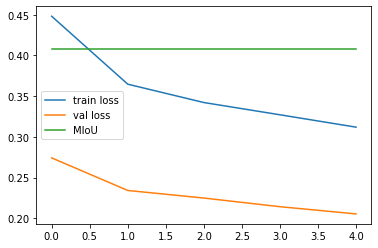

In [19]:
plt.plot(r_losses, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.plot(miou_epoch, label = 'MIoU')
plt.legend()
plt.show()

Сохранил модель с самым лучшим показателем

In [96]:
torch.save(model.cpu(), './model.sav')

Вывел MIOU в развёрстке по классам

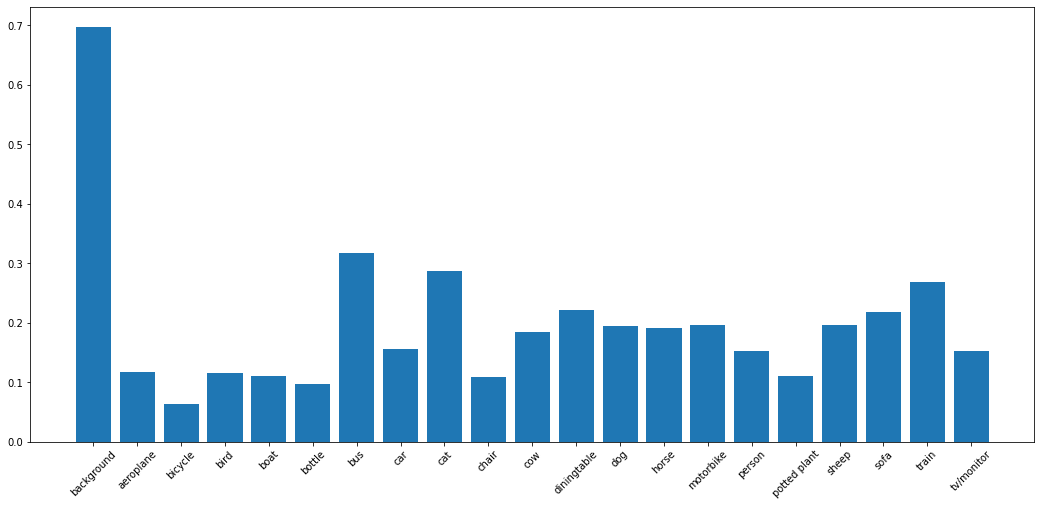

In [22]:
m_iou = M_IoU(iou)
plt.figure(figsize = (18, 8))
plt.bar(VOC_CLASSES, m_iou)
plt.xticks(rotation=45)
plt.show()

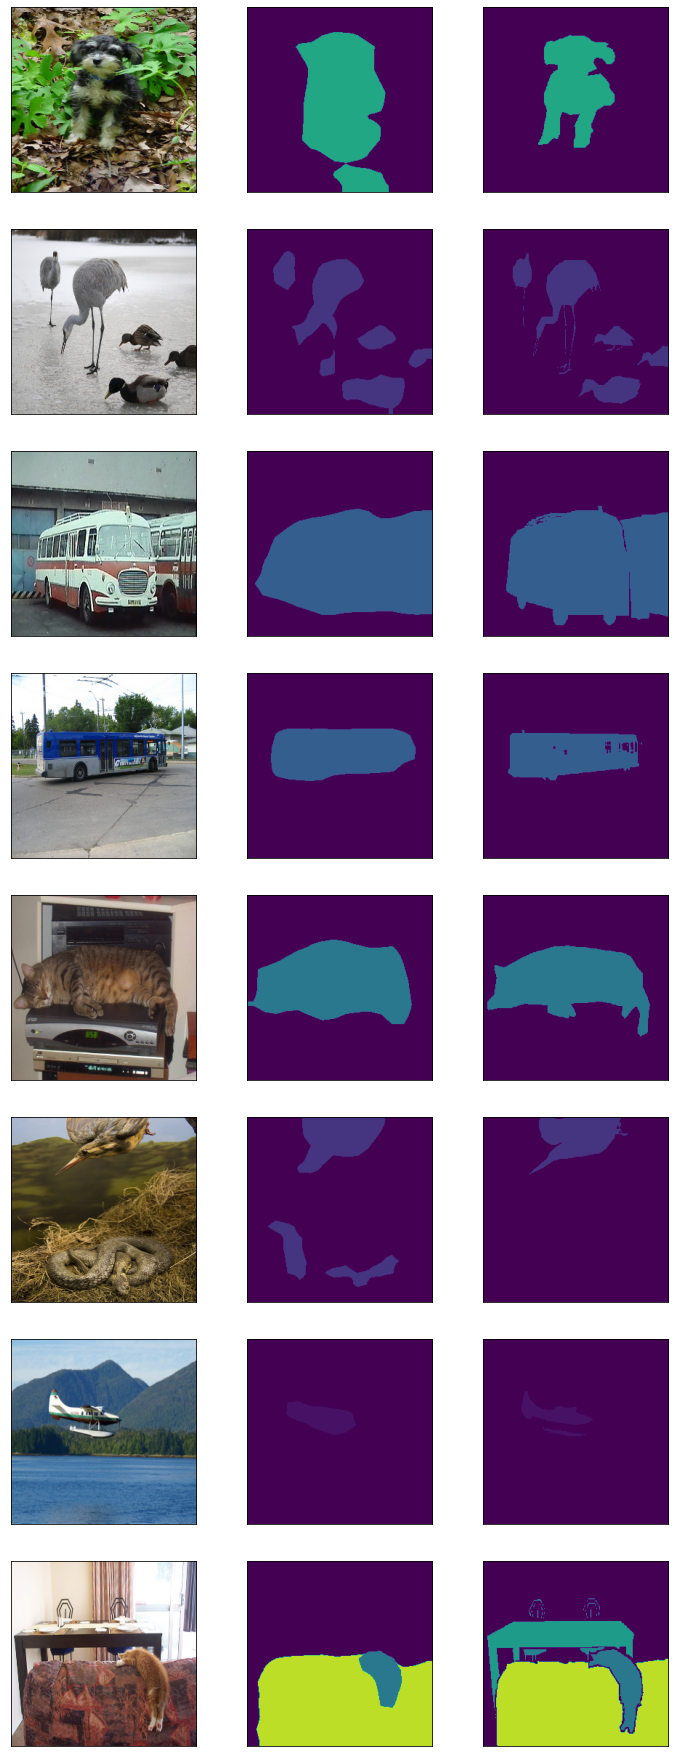

In [50]:
fig,axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

Написал функцию поиска лучшего по метрике изображения в 3х классах

In [85]:
def best_img_in_three_class(iou, dataset, n1, n2, n3):
  iou = torch.tensor(iou)
  max = 0
  for i in range(len(iou)):
    if iou[i][n1] != 0 and iou[i][n2] != 0 and iou[i][n3] != 0:
      if iou[i][n1] + iou[i][n2] + iou[i][n3] > max:
        max = iou[i][n1] + iou[i][n2] + iou[i][n3]
        max_i = i
  if max_i:
    print_img(dataset, max_i)
  else:
    print(f'no img with {n1}, {n2}, {n3} classes simultaneously')

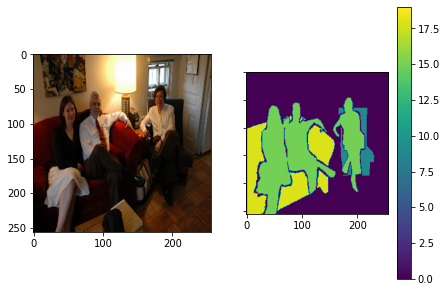

In [86]:
best_img_in_three_class(iou, validation_dataset, 0, 9, 11)

Написал функции выбора 2 случайных каринок, попадающих в промежутки: 10%, 15-25%, 45-55%

In [90]:
def two_best_img_corr(miou, dataset, l, r, k = 2):
  id = np.array([i for i in range(len(miou))])
  sorted_miou = np.copy(miou)
  for i in range(len(miou) - 1):
    for j in range(len(miou) - i - 1):
        if sorted_miou[j] < sorted_miou[j+1]:
            sorted_miou[j], sorted_miou[j+1] = sorted_miou[j+1], sorted_miou[j]
            id[j], id[j+1] = id[j+1], id[j]
  for i in range(k):
    print_img(dataset, np.random.choice(id[int(len(id) * l) : int(len(id) * r)]))

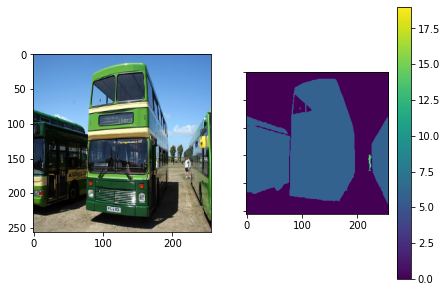

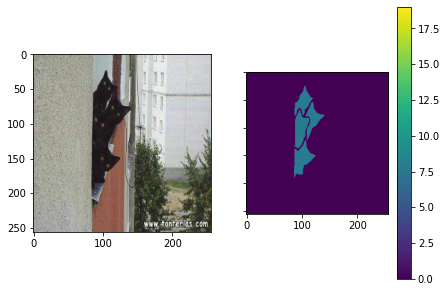

In [92]:
two_best_img_corr(miou, validation_dataset, 0, 0.1)

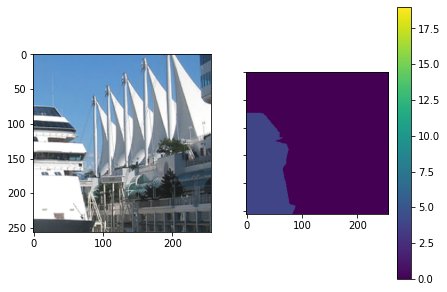

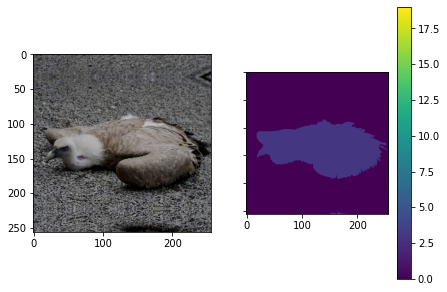

In [93]:
two_best_img_corr(miou, train_dataset, 0.15, 0.25)

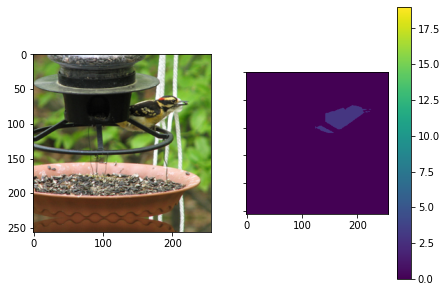

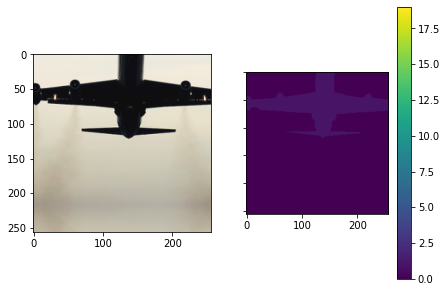

In [94]:
two_best_img_corr(miou, train_dataset, 0.45, 0.55)

#### Задание 
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
** При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять. 



